In [65]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import optuna
from numpy import concatenate

# Example time series: Airline passengers
from statsmodels.datasets import get_rdataset
dataset_object = get_rdataset(dataname ='AirPassengers')

df = dataset_object.data


display(df)

,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121
...,...,...
139,1960.583333,606
140,1960.666667,508
141,1960.750000,461
142,1960.833333,390


In [66]:
series = df['value'].values

In [67]:
set_length = len(series)

num_train_samples = 0.8*set_length

num_train_samples = int(num_train_samples)

train_data = series[:num_train_samples]  # First 120 months

In [68]:
# Optuna objective function
def objective(trial):
    p = trial.suggest_int('p', 1, 5)
    d = trial.suggest_int('d', 1, 2)
    q = trial.suggest_int('q', 1, 5)

    pdq_tuple = (p, d, q)
    
    model = ARIMA(endog=train_data, order=pdq_tuple)
    model = model.fit()
    forecast = model.predict(start=0, end=set_length - 1)
    error = mean_squared_error(series, forecast)
    return error

In [69]:
# Run Optuna optimization
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=50)

best_params = study.best_params

# Best parameters
print("Best ARIMA parameters:", best_params)

[I 2025-07-15 20:55:36,424] A new study created in memory with name: no-name-1545f8ad-93b9-41e9-91f3-26597a67102e
/workspaces/eargweth/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/eargweth/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2025-07-15 20:55:36,911] Trial 0 finished with value: 1608.2063445070771 and parameters: {'p': 2, 'd': 2, 'q': 5}. Best is trial 0 with value: 1608.2063445070771.
/workspaces/eargweth/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramet

Best ARIMA parameters: {'p': 4, 'd': 1, 'q': 5}


In [70]:
# Fit best model and plot forecast
best_params = study.best_params

p = best_params['p']
d = best_params['d']
q = best_params['q']

param_tuple = (p, d, q)
model = ARIMA(series, order=param_tuple)
model = model.fit()
forecast = model.predict(start=0, end=set_length - 1)

/workspaces/eargweth/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/eargweth/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/eargweth/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [73]:
out_sample_data = series[num_train_samples:]

out_sample_index_list = range(num_train_samples, set_length)

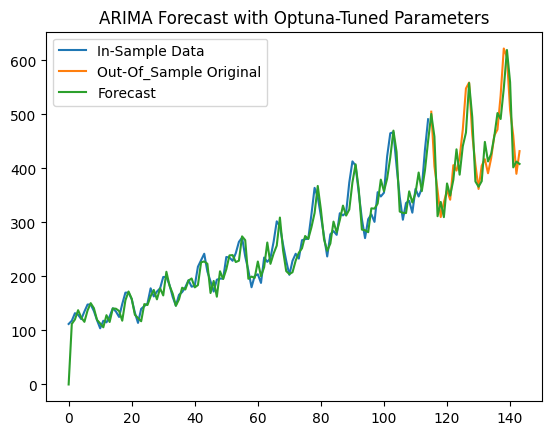

In [74]:
from matplotlib import pyplot as plt
plt.plot(train_data, label='In-Sample Data')
plt.plot(out_sample_index_list, out_sample_data, label='Out-Of_Sample Original')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('ARIMA Forecast with Optuna-Tuned Parameters')
plt.show()
